In [10]:
from trainer.data import load_data, load_data_from_list
from trainer.policy import get_model
from trainer.env import make_env
from trainer.preprocessing import make_observation_window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from trade_tester.tester import render_candles
import xarray as xr

from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras import layers
import tensorflow as tf
from keras.optimizers import Adam
# отключим GPU (нужно для платформы Apple M1)
tf.config.set_visible_devices([], 'GPU')

In [ ]:
load_data_kwargs = dict(
    path = 'klines/',
    symbol = 'DOGEUSDT',
    tf='15m',
    preprocessing_kwargs = dict(
        bb = dict(period=20, render=True, deviation=1.8),
        rsi = dict(period=14, render=True, separately=True, color='blue'),
        # ma = dict(period=20, render=True, color='red'),
        obv = dict(render=True, color='green', separately=True),
    ),
    split_validate_percent = 0,
)
train_klines, val_klines, indicators = load_data(**load_data_kwargs)

In [ ]:
train_klines

In [ ]:
env_kwargs = dict(
    env_class='TradingEnv2Actions',
    tester='BBFutureTester2',
    klines=train_klines,
    indicators=indicators,
    b_size=1000,
)
env = make_env(**env_kwargs)
# model = get_model(env=env)
# model = PPO('MlpPolicy', env)

In [ ]:
done=False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step([action])
    env.render()

In [ ]:
model.policy._modules

In [ ]:
# Извлеките параметры политики
policy_parameters = model.policy.state_dict()
# Выведите веса каждого слоя
for name, weights in policy_parameters.items():
    print(f"{name}: {weights}")

In [ ]:
# Исследование структуры model.policy
def explore_structure(obj, indent=0):
    for name in dir(obj):
        if not name.startswith("__"):
            value = getattr(obj, name)
            if not callable(value):
                print("  " * indent, f"{name}: {type(value)}")
                if isinstance(value, torch.nn.Module):
                    explore_structure(value, indent + 1)

# print("Policy structure:")
# explore_structure(model.policy)

In [ ]:
obs = env.reset()
obs = th.tensor(obs)
obs = obs.transpose(1, 2)[0]
for channel in range(obs.shape[0]):
    print()

In [ ]:
from trainer.nn import CustomNN

nn = CustomNN(np.array([[9, 300], [9, 300]]))

In [ ]:
nn.named_parameters

In [ ]:
for name, param in nn.named_parameters():
    num_params = param.numel()
    print(num_params)

In [ ]:
kwargs = dict(
    symbols = ['DOGEUSDT', 'DOGEBTC', 'BTCUSDT'],
    tfs = ['15m', '30m', '1h', '4h'],
    preprocessing_kwargs = dict(
                    bb = dict(period=20, deviation=2),
                    rsi = dict(period=14),
                    ma = dict(period=20),
                    obv = dict(),
                ),
)
dfs = load_data_from_list(**kwargs)

In [ ]:
# find min and max date over dfs
min_dates = []
for df in dfs:
    min_dates.append(df['date'].min())
min_date = max(min_dates)

# shrink dataset so that the minimum date is the same
dfs2 = []
for df in dfs:
    dfs2.append(df[df['date'] >= min_date].reset_index(drop=True))
dfs = dfs2

In [ ]:
len(dfs[0])

In [ ]:
dataset = []
window = 100
length = len(dfs[0]) - window
for i in range(1600+window+1, window+length):
    a = make_observation_window(dfs, date=dfs[0].iloc[i][0], window=window)
    dataset.append(a)

In [ ]:
dataset = np.array(dataset)
dataset.shape

In [ ]:
# Создаем xarray.DataArray с метками
date = dfs[0][:dataset.shape[0]]['date'].values
dataset = xr.DataArray(
    dataset,
    coords={'date': date},
    dims=['date', 'n', 'chanel']
)
dataset.to_netcdf('dataset.nc')

In [2]:
dataset = xr.open_dataarray('dataset.nc')

In [4]:
dataset.shape

(94833, 100, 144)

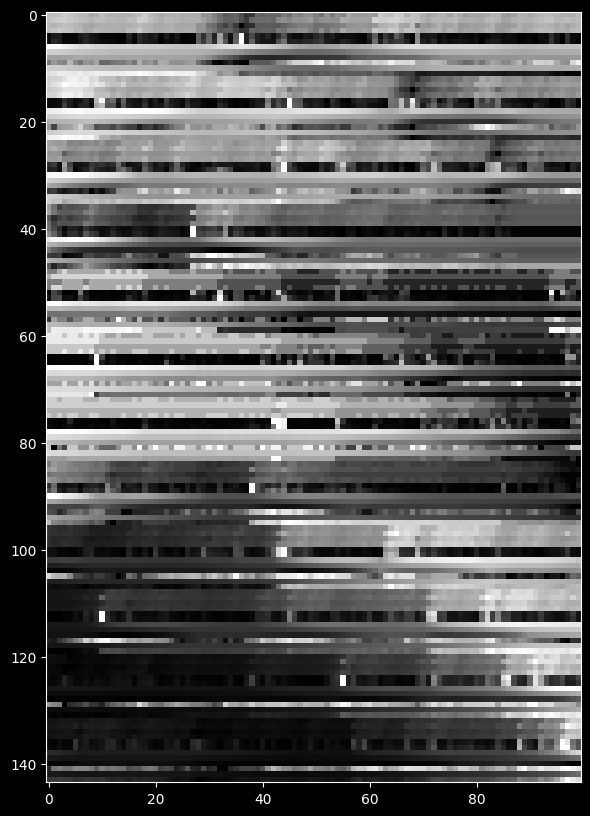

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(train_data[0].transpose(), cmap='gray')

In [7]:
# Разделение данных на обучающую и тестовую выборки
split_index = int(0.8 * dataset.shape[0])
train_data = dataset[:split_index]
test_data = dataset[split_index:]

In [11]:
# Создание модели автоэнкодера на основе Conv1D
input_layer = layers.Input(shape=(100, 144))
encoder = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
encoder_output = layers.MaxPooling1D(pool_size=2, padding='same')(encoder)

decoder_input = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(encoder_output)
decoder = layers.UpSampling1D(size=2)(decoder_input)
decoder_output = layers.Conv1D(filters=144, kernel_size=3, activation='linear', padding='same')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# Компиляция и обучение модели
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.fit(train_data, train_data,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data))

Epoch 1/20


2023-04-14 11:25:38.824153: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


593/593 [==============================] - 19s 32ms/step - loss: 0.0216 - val_loss: 0.0118
Epoch 2/20
593/593 [==============================] - 18s 30ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 3/20
593/593 [==============================] - 18s 30ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 4/20
593/593 [==============================] - 18s 30ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 5/20
593/593 [==============================] - 18s 30ms/step - loss: 0.0094 - val_loss: 0.0086
Epoch 6/20
593/593 [==============================] - 18s 31ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 7/20
593/593 [==============================] - 18s 31ms/step - loss: 0.0083 - val_loss: 0.0076
Epoch 8/20
593/593 [==============================] - 19s 32ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 9/20
593/593 [==============================] - 18s 31ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 10/20
593/593 [==============================] - 18s 31ms/step - loss: 0.0069 - val_los